<a href="https://colab.research.google.com/github/mayankjain0141/deep-learning/blob/main/Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP with TensorFlow
Solving sequence problems
Examples of sequences - Sentential, Speech etc. 

General Flow -
text->numbers->build a model->train->predict

In [69]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4b05ee80-2711-b1b7-0b94-158667c3ec59)


In [70]:
# Get helper functions
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-08 17:01:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-08 17:01:42 (67.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [71]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [72]:
# Downloading dataset
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-11-08 17:01:42--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-11-08 17:01:42 (99.4 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



3 CSV Files - 
1. sample_submission.csv -> Submission file for kaggle
2. train.csv -> training samples
3. test.csv -> testing samples

# Step 1 : Explore and Visualize the dataset

In [73]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [74]:
# Shuffling just to be sure
train_df_shuffled = train_df.sample(frac = 1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [75]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [76]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Fairly balanced dataset, binary classification

In [77]:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total Samples: {len(test_df)+len(train_df)}")

Total training samples: 7613
Total test samples: 3263
Total Samples: 10876


Good proportion of train vs test samples

Visualizing Random Text Samples - 
To get a better idea of different types of data we're dealing with


In [78]:
import random
random_idx = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_idx:random_idx+5].itertuples():
  _,text, target = row
  print(f"Target:{target}","(real disaster)" if target>0 else "(Not real disaster)")
  print(f"Text:\n{text}\n\n")

Target:0 (Not real disaster)
Text:
RT alisonannyoung: EXCLUSIVE: FedEx no longer to transport research specimens of bioterror pathogens in wake of anthrax lab mishaps Û_


Target:1 (real disaster)
Text:
16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/n7Yst76ku3


Target:0 (Not real disaster)
Text:
@gfrost1985 @jeffpalmer16 @MLB @BlueJays why you so salty and scared when we have a drought like you said?


Target:0 (Not real disaster)
Text:
Wow! I just won this for free The Hobbit: Desolation of Smaug UV digital download code *GIN 9 http://t.co/MjFdCrjs8j #listia


Target:0 (Not real disaster)
Text:
@5hvzlaRadio Love what you picked! We're playing WORTH IT by FIFTH HARM/KID INK because of you! Listen &amp; Vote: http://t.co/0wrATkA2jL




##Creating Training and Validation Sets
Since our test data doesnt have target labels, we create validation set to evaluate our model

In [79]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, 
                                                                            random_state=42) 

In [80]:
# Checking Lengths 
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [81]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

# Step 2 - Converting text into numbers

2 main concepts - 
1. Tokenization - Straight mapping from token to number. (Can be modelled but quickly gets too big)
  
  - Word level - Each word as a token
  - Character Level - Each char as a token
  - Sub word level - Breaking words into smaller words and then word level
2. Embeddings - 
  It is a feature vector representation. Size is tuneable. 
  - Create own embeddings - Pass numbers through embedding layer and an embedding representation will be learned during training. 
  - Reuse Pre-learned embeddings -
  Fine-tune to own specific task. 

When to use what?
 - Can try both
 - Even try stacking them(tf.keras.layers.concatenate)

Some pretrained word embeddings -
1. Word2vec
2. GloVe
3. Others on TensorFlow Hub


Text vectorization - Tokenization

In [82]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = None, # Num_words in vocab
                                    standardize = "lower_and_strip_punctuation", # How to process text
                                    split = "whitespace", # How to split tokens
                                    ngrams = None, # Grouping words by n
                                    output_mode = "int", # How to map tokens to nums
                                    output_sequence_length=None) # Length of output sequence of tokens


In [83]:
# Average number of tokens per tweet
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [84]:
max_vocab_length = 10000
max_length = 15
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [85]:
text_vectorizer.adapt(train_sentences) # Mapping vectorizer to our data

In [86]:
sample_sentence = "This is a test sentence"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  19,    9,    3, 1246,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [87]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Top 5 most common words in vocab: {top_5_words}")
print(f"Bottom 5 least common words in vocab: {bottom_5_words}")

Top 5 most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


Creating an Embedding using Embedding Layer

In [88]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer = "uniform",
                             input_length = max_length,
                             name="embedding_1")

In [89]:
test_embed = embedding(text_vectorizer([random.choice(train_sentences)]))
test_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03977952, -0.03782602, -0.03646283, ...,  0.00236253,
          0.03332629,  0.02803668],
        [-0.01238489, -0.01569571,  0.04614357, ...,  0.00714378,
         -0.04799243, -0.04700608],
        [-0.01303345, -0.0456596 , -0.017446  , ..., -0.04159649,
          0.00482054, -0.00569761],
        ...,
        [-0.001433  ,  0.0300638 ,  0.04238715, ..., -0.02947466,
          0.00146668,  0.04801163],
        [-0.04434322,  0.01179806, -0.02017307, ..., -0.02111288,
         -0.02605996, -0.03443655],
        [ 0.00844773,  0.04473772, -0.02800121, ...,  0.03848464,
         -0.02030778,  0.02029306]]], dtype=float32)>

Modelling a text dataset - 

Here I am going to test 7 different models:
- Naive Bayes(baseline)
- Feed forward NN (dense)
- LSTM model
- GRU model
- Bidirectional LSTM
- 1D Convolutional NN
- TfHub pretrained feature Extractor
- Same as prev with 10% of training data

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [91]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline Accuracy :{baseline_score*100:.2f}%")

Baseline Accuracy :79.27%


In [92]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:5]

array([1, 1, 1, 0, 0])

Evaluation Function for model Experiments
- Accuracy
- Precision
- Recall
- F1-score

If it were a regression problem we would have used MAE and other such metrics

In [93]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
  model_results = {
      "accuracy":model_accuracy,
      "precision":model_precision,
      "recall":model_recall,
      "f1":model_f1
  }
  return model_results

In [94]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# Model 1: Dense Model

In [95]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [96]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [97]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [98]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_3 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20211108-170144
Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [100]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [101]:
!tensorboard dev upload --logdir ./model_logs \
  --name "First deep model on text data" \
  --description "Trying a dense model with an embedding layer" \
  --one_shot # exits the uploader when upload has finished

2021-11-08 17:01:58.233406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 17:01:58.242786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 17:01:58.243454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Pol

In [102]:
model_1_pred_probs = model_1.predict(val_sentences) # Since last layer is sigmoid
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.7874015748031497,
 'f1': 0.7846966492209201,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497}

In [103]:
def compare_results(baseline_results,new_model_results):
  for key,value in baseline_results.items():
    print(f"Baseline {key}:{value:.2f}, New {new_model_results[key]:.2f}, Difference = {new_model_results[key]-value:.2f}")

In [104]:
compare_results(baseline_results,model_1_results)

Baseline accuracy:0.79, New 0.79, Difference = -0.01
Baseline precision:0.81, New 0.79, Difference = -0.02
Baseline recall:0.79, New 0.79, Difference = -0.01
Baseline f1:0.79, New 0.78, Difference = -0.00


In [105]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073164,  0.01504798, -0.03425455, ..., -0.04403539,
         -0.0104228 ,  0.01876438],
        [ 0.04135861, -0.03945087, -0.03811941, ...,  0.00464736,
          0.03163552,  0.02928299],
        [ 0.00684032,  0.05363133, -0.00241555, ..., -0.07082178,
         -0.04750704,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018393,  0.03510419],
        [-0.0372346 ,  0.06267187, -0.07451146, ..., -0.02367217,
         -0.08643331,  0.01742156]], dtype=float32)>]

In [106]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


# Model 2 - LSTM 

In [107]:
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [108]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_3 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [109]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20211108-170203
Epoch 1/5
215/215 [==============================] - 5s 15ms/step - loss: 0.5074 - accuracy: 0.7486 - val_loss: 0.4572 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3160 - accuracy: 0.8727 - val_loss: 0.5181 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2197 - accuracy: 0.9172 - val_loss: 0.5702 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1548 - accuracy: 0.9461 - val_loss: 0.6502 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1087 - accuracy: 0.9600 - val_loss: 0.8393 - val_accuracy: 0.7585


In [110]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7585301837270341,
 'f1': 0.7566051475454213,
 'precision': 0.7593999956661763,
 'recall': 0.7585301837270341}

In [111]:
compare_results(baseline_results, model_2_results)

Baseline accuracy:0.79, New 0.76, Difference = -0.03
Baseline precision:0.81, New 0.76, Difference = -0.05
Baseline recall:0.79, New 0.76, Difference = -0.03
Baseline f1:0.79, New 0.76, Difference = -0.03


# Model 3 : GRU

In [112]:
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [113]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_3 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [114]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20211108-170227
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5265 - accuracy: 0.7269 - val_loss: 0.4521 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3192 - accuracy: 0.8683 - val_loss: 0.4883 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2192 - accuracy: 0.9178 - val_loss: 0.5590 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1601 - accuracy: 0.9426 - val_loss: 0.6068 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1213 - accuracy: 0.9590 - val_loss: 0.6090 - val_accuracy: 0.7677


In [115]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 0.7677165354330708,
 'f1': 0.7669760007914206,
 'precision': 0.7674148766835972,
 'recall': 0.7677165354330708}

In [116]:
compare_results(baseline_results, model_2_results)

Baseline accuracy:0.79, New 0.76, Difference = -0.03
Baseline precision:0.81, New 0.76, Difference = -0.05
Baseline recall:0.79, New 0.76, Difference = -0.03
Baseline f1:0.79, New 0.76, Difference = -0.03


# Model 4: Bidirectional RNN model

In [117]:
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [118]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_3 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [119]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20211108-170243
Epoch 1/5
215/215 [==============================] - 9s 22ms/step - loss: 0.5114 - accuracy: 0.7446 - val_loss: 0.4609 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3129 - accuracy: 0.8729 - val_loss: 0.5253 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2122 - accuracy: 0.9186 - val_loss: 0.5790 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1403 - accuracy: 0.9548 - val_loss: 0.6756 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1010 - accuracy: 0.9642 - val_loss: 0.7071 - val_accuracy: 0.7598


In [120]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)
compare_results(baseline_results, model_4_results)

Baseline accuracy:0.79, New 0.76, Difference = -0.03
Baseline precision:0.81, New 0.76, Difference = -0.05
Baseline recall:0.79, New 0.76, Difference = -0.03
Baseline f1:0.79, New 0.76, Difference = -0.03


Model 5: Using pretrained embeddings

In [121]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[ 0.04748859 -0.04986643 -0.01711429  0.02992413 -0.05266668 -0.05958213
  0.00611429  0.0335059   0.04449555  0.03384266  0.01854087 -0.04166462
  0.07370758  0.05725546  0.01805998 -0.07430238  0.00206889  0.04645026
  0.0452926  -0.08287052 -0.00168109  0.05973099 -0.0628479   0.01113377
 -0.06626558  0.03790153 -0.00923612 -0.05679002  0.01125833 -0.05016017
  0.0557582  -0.04208621  0.01507832 -0.01503576 -0.06931743 -0.00172351
  0.00731807 -0.02838836  0.03563856  0.06780129 -0.02562177  0.01150593
  0.01658367  0.0562694  -0.03362058 -0.00990153 -0.01879578 -0.01589944
 -0.00069078  0.01129317], shape=(50,), dtype=float32)


In [122]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [123]:
model_5 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_5_USE")

# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [124]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211108-170317
Epoch 1/5
215/215 [==============================] - 11s 34ms/step - loss: 0.5020 - accuracy: 0.7882 - val_loss: 0.4491 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4147 - accuracy: 0.8136 - val_loss: 0.4376 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.4002 - accuracy: 0.8212 - val_loss: 0.4333 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3931 - accuracy: 0.8259 - val_loss: 0.4284 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3870 - accuracy: 0.8291 - val_loss: 0.4302 - val_accuracy: 0.8136


In [125]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.8136482939632546,
 'f1': 0.8120618868299143,
 'precision': 0.8160661319598898,
 'recall': 0.8136482939632546}

In [126]:
compare_results(baseline_results, model_5_results)

Baseline accuracy:0.79, New 0.81, Difference = 0.02
Baseline precision:0.81, New 0.82, Difference = 0.00
Baseline recall:0.79, New 0.81, Difference = 0.02
Baseline f1:0.79, New 0.81, Difference = 0.03


In [127]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,                                  
                                  "tf_hub_sentence_encoder": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.758530,0.759400,0.758530,0.756605
gru,0.767717,0.767415,0.767717,0.766976
bidirectional,0.759843,0.759527,0.759843,0.758984
tf_hub_sentence_encoder,0.813648,0.816066,0.813648,0.812062


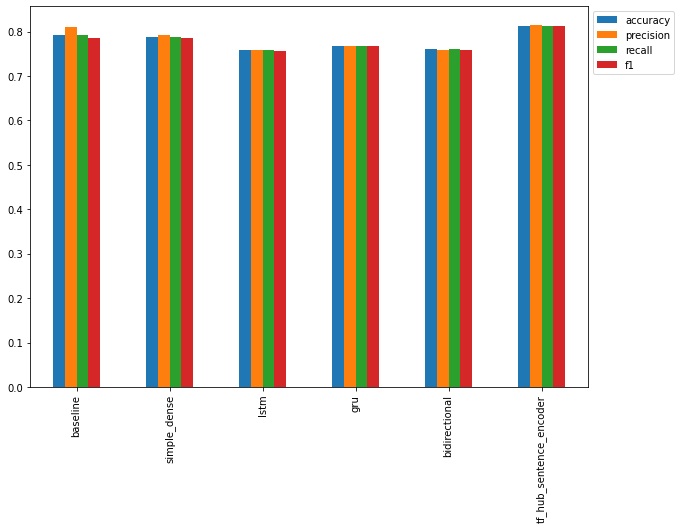

In [128]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));